# ANOVA dumb group name - housing price prediction

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

In [2]:
# Read in the train and test data
train_data = pd.read_csv("data/train.csv", index_col = 0, encoding = "utf-8")
sale_price = train_data[['SalePrice']]
test_data = pd.read_csv("data/test.csv", index_col = 0, encoding = "utf-8")
test_data['SalePrice'] = 0

In [3]:
# Combine the train and test data for the moment, so manipulations are applied to both
all_data = pd.concat([train_data, test_data], axis = 0).reset_index(drop = True)

###### Target is highly skewed! Use a transformation to correct

True


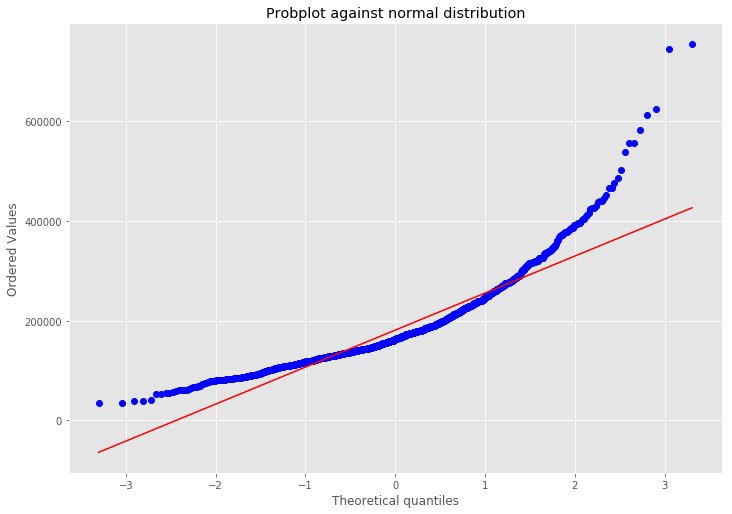

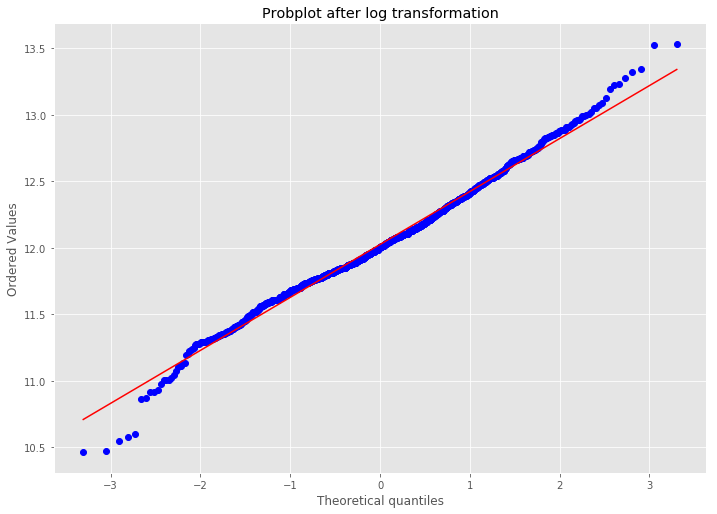

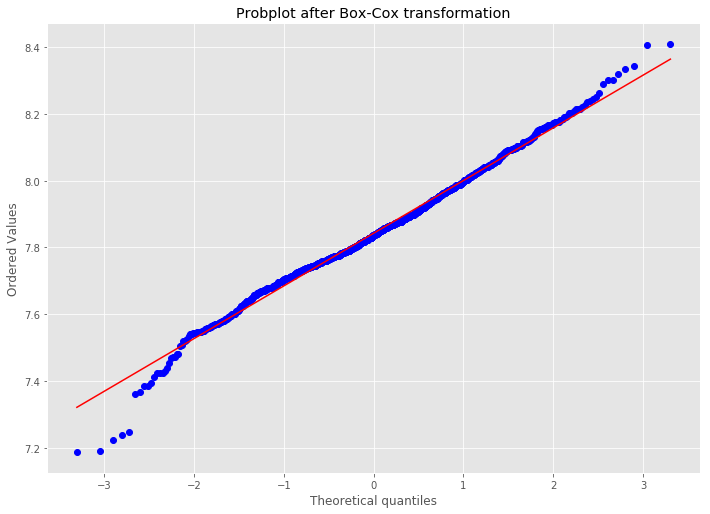

In [4]:
# Compare normality of target under no transformation, optimum box-cox and log
fig1, ax1 = plt.subplots(figsize=(11.7, 8.27))
prob1 = stats.probplot(sale_price['SalePrice'], dist=stats.norm, plot=ax1)
ax1.set_title('Probplot against normal distribution')

print(all(sale_price['SalePrice'] > 0))
fig2, ax2 = plt.subplots(figsize=(11.7, 8.27))
sale_price_log = stats.boxcox(sale_price, lmbda = 0)
prob2 = stats.probplot(sale_price_log.flatten(), dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after log transformation')

fig3, ax3 = plt.subplots(figsize=(11.7, 8.27))
sale_price_bc, lmbda = stats.boxcox(sale_price)
prob3 = stats.probplot(sale_price_bc.flatten(), dist=stats.norm, plot=ax3)
ax3.set_title('Probplot after Box-Cox transformation')

plt.show()
# Optimal Lambda is -0.07692396

(array([0.02796873, 0.05593746, 0.15662488, 0.72159319, 2.38293564,
        2.48362306, 1.51031132, 0.62090577, 0.16221862, 0.04474997]),
 array([7.18570046, 7.30814641, 7.43059237, 7.55303832, 7.67548427,
        7.79793022, 7.92037617, 8.04282212, 8.16526808, 8.28771403,
        8.41015998]),
 <a list of 10 Patch objects>)

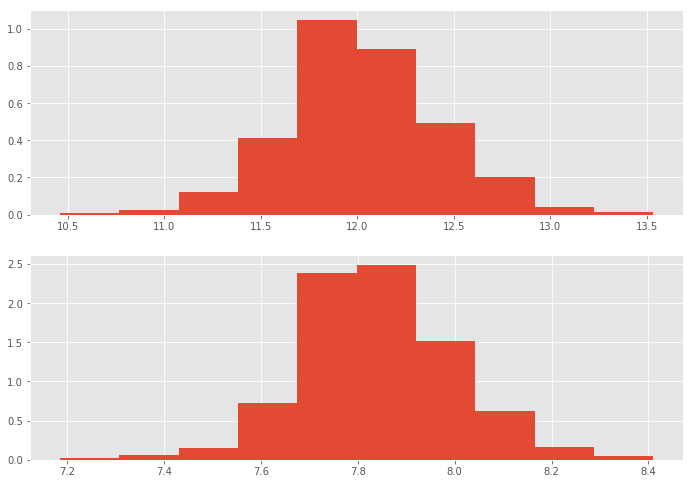

In [5]:
# Plot histograms of the lob and box-cos transformed target data
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(11.7, 8.27))
ax0, ax1, = axes.flatten()
ax0.hist(sale_price_log, density = True)
ax1.hist(sale_price_bc, density = True)

###### The target data transformed by the logarithm (lambda = 0) looks pretty good and is more easily interpreted - continue with this

### Investigating missingness

In [6]:
# Get an overview of the feature set
all_data.describe()
# 37 numerical variables inc. SalePrice

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,90491.588215
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,106496.379333
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,0.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,34900.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,163000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [7]:
all_data.columns[all_data.isnull().any()]
# 25 features with missing data

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')

In [8]:
# View the columns with missing data
all_data.loc[:, ['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType']]

,MSZoning,LotFrontage,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType
0,RL,65.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,...,2003.0,RFn,2.0,548.0,TA,TA,NaN,NaN,NaN,WD
1,RL,80.0,NaN,AllPub,MetalSd,MetalSd,None,0.0,Gd,TA,...,1976.0,RFn,2.0,460.0,TA,TA,NaN,NaN,NaN,WD
2,RL,68.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,...,2001.0,RFn,2.0,608.0,TA,TA,NaN,NaN,NaN,WD
3,RL,60.0,NaN,AllPub,Wd Sdng,Wd Shng,None,0.0,TA,Gd,...,1998.0,Unf,3.0,642.0,TA,TA,NaN,NaN,NaN,WD
4,RL,84.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,...,2000.0,RFn,3.0,836.0,TA,TA,NaN,NaN,NaN,WD
5,RL,85.0,NaN,AllPub,VinylSd,VinylSd,None,0.0,Gd,TA,...,1993.0,Unf,2.0,480.0,TA,TA,NaN,MnPrv,Shed,WD
6,RL,75.0,NaN,AllPub,VinylSd,VinylSd,Stone,186.0,Ex,TA,...,2004.0,RFn,2.0,636.0,TA,TA,NaN,NaN,NaN,WD
7,RL,NaN,NaN,AllPub,HdBoard,HdBoard,Stone,240.0,Gd,TA,...,1973.0,RFn,2.0,484.0,TA,TA,NaN,NaN,Shed,WD
8,RM,51.0,NaN,AllPub,BrkFace,Wd Shng,None,0.0,TA,TA,...,1931.0,Unf,2.0,468.0,Fa,TA,NaN,NaN,NaN,WD
9,RL,50.0,NaN,AllPub,MetalSd,MetalSd,None,0.0,TA,TA,...,1939.0,RFn,1.0,205.0,Gd,TA,NaN,NaN,NaN,WD


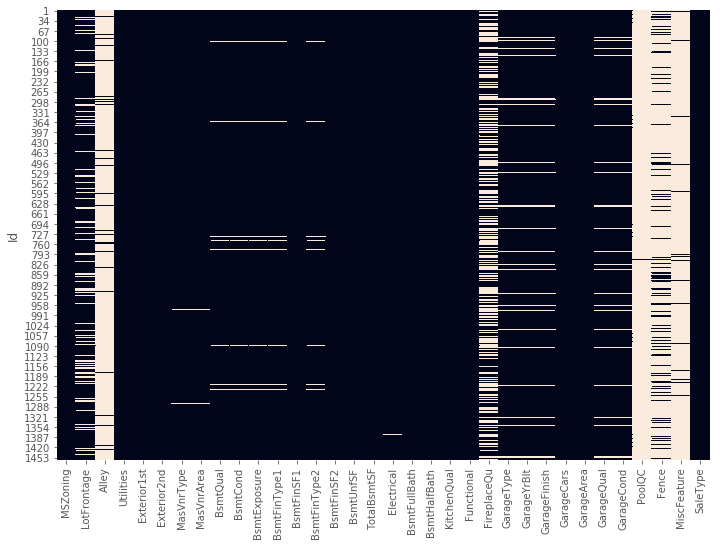

In [9]:
# Visualize missing data combinations
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.heatmap(train_data.loc[:, ['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType']].isnull(), cbar = False, ax=ax)

### Data cleaning and preliminary feature selection
Most appropriate method of imputation has been selected for each feature based on missingness quantity, pattern, feature characteristics and feature importance

In [10]:
# Replace the missing values from the basement data with random selections from the appropriate options
np.random.seed(0)
basement = all_data.loc[:,['BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',]]
basement[(basement.isnull().any(axis = 1)) & (basement.loc[:,'TotalBsmtSF'] != 0)] =\
basement[(basement.isnull().any(axis = 1)) & (basement.loc[:,'TotalBsmtSF'] != 0)].apply(lambda x: x.fillna(np.random.choice(x.dropna())), axis=0)

# Replace the NA's that correspond to no garage with "None"
basement.loc[basement.isnull().any(axis = 1),['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = "None"
all_data.loc[:,['BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',]] = basement

# Remove the singular missing completely at random observation in the electrical column
all_data = all_data.drop(all_data[all_data.loc[:,'Electrical'].isnull()].index[0], axis = 0)

# Replace all NA values that actually mean no fireplaces with 'None'
all_data.loc[(all_data['FireplaceQu'].isnull()) & (all_data['Fireplaces'] == 0),'FireplaceQu'] = "None"

# Replace all NA values that actually mean no garage with 'None'
all_data.loc[(all_data['GarageType'].isnull()) &(all_data['GarageArea'] == 0),'GarageType'] = 'None'
all_data.loc[(all_data['GarageFinish'].isnull()) &(all_data['GarageArea'] == 0),'GarageFinish'] = 'None'
all_data.loc[(all_data['GarageQual'].isnull()) &(all_data['GarageArea'] == 0),'GarageQual'] = 'None'

# Impute for the very few missing values in the GarageQual and GarageFinish
GarFin_index = (all_data[(all_data.GarageArea!=0) & (all_data.GarageFinish.isnull())]['GarageFinish']).index
GarQual_index  = (all_data[(all_data.GarageArea!=0) & (all_data.GarageQual.isnull())]['GarageQual']).index
all_data.loc[GarQual_index,'GarageQual'] = np.random.choice(['TA', 'Fa', 'Gd','Ex', 'Po'])
all_data.loc[GarFin_index,'GarageFinish'] = np.random.choice(['Fin','RFn','Unf'])

# Impute using the mean/median for the very few missing values in the other garage columns
all_data.loc[(all_data['GarageYrBlt'].isnull()) &(all_data['GarageArea'] == 0),'GarageYrBlt'] = 'None'
all_data.loc[2576,'GarageArea'] = all_data.GarageArea.mean()
all_data.loc[2576,'GarageCars'] = all_data.GarageCars.mean()
all_data.loc[[2126,2576],'GarageYrBlt'] = all_data.GarageYrBlt[all_data.GarageYrBlt != 'None'].median()

# Replace all NA values that actualy mean no pool with "None"
all_data.loc[(all_data['PoolQC'].isnull()) & (all_data['PoolArea'] == 0),'PoolQC'] = 'None'

# Impute for the very few missing values in the PoolQC column
poolna_index = (all_data[(all_data.PoolArea!=0) & (all_data.PoolQC.isnull())]['PoolQC']).index
all_data.loc[poolna_index[0],'PoolQC'] = np.random.choice(['Ex','Gd','Fa'])
all_data.loc[poolna_index[1],'PoolQC'] = np.random.choice(['Ex','Gd','Fa'])
all_data.loc[poolna_index[2],'PoolQC'] = np.random.choice(['Ex','Gd','Fa'])
all_data.loc[poolna_index,'PoolQC']

# Replace all NA values that actualy mean no fence with "None"
all_data['Fence'].fillna(value='None', inplace=True)

# Replace the only NA value with the majority value Typ
all_data['Functional'].fillna(value='Typ', inplace=True)

# Replace the remaining couple of NA values in the BsmtBath columns with values that preserve the column means
all_data.loc[2120, 'BsmtFullBath'] = 1
all_data.loc[2188, 'BsmtFullBath'] = 0
all_data['BsmtHalfBath'].fillna(value=0, inplace=True)

# Replace all NA values that actualy mean no fence with "None"
all_data.loc[(all_data.MiscFeature.isnull()) & (all_data.MiscVal == 0),'MiscFeature'] = 'None'

# Replace the missing value in MicsFeature according to its corresponding MiscValue
all_data.loc[all_data.MiscFeature.isnull(), 'MiscFeature'] = 'Gar2'

# Replace missing values in the Exterior columns with majority values
all_data.loc[all_data.Exterior1st.isnull(),'Exterior1st'] = 'VinylSd'
all_data.loc[all_data.Exterior2nd.isnull(),'Exterior2nd'] = 'VinylSd'
all_data.loc[all_data.MSZoning.isnull(),'MSZoning'] = 'RL'
all_data.loc[all_data.SaleType.isnull(),'SaleType'] = 'WD'
all_data.loc[all_data.KitchenQual.isna(), 'KitchenQual'] = 'Ta'

In [11]:
# For those columns with a larger number of truly missing values, randomly impute
all_lf_index = (all_data[all_data.LotFrontage.isnull()]).index
for idx in all_lf_index:
    all_data.loc[idx,'LotFrontage'] = np.random.choice(all_data.LotFrontage.dropna(), replace = False)

all_mvt_index = (all_data[all_data.MasVnrType.isnull()]).index
for idx in all_mvt_index:
    all_data.loc[idx,'MasVnrType'] = np.random.choice(['None', 'BrkFace', 'Stone'], replace = True)

all_mva_index = (all_data[all_data.MasVnrArea.isnull()]).index
for idx in all_mva_index:
    all_data.loc[idx,'MasVnrArea'] = np.random.choice(all_data.MasVnrArea.dropna(), replace = False)

In [12]:
# Get rid of those columns that take almost exlcusively one value, and hence will ofer little to no information
all_data = all_data.drop(["Street","Alley","Utilities", "BldgType", 'HouseStyle', 'YearBuilt', 'RoofMatl', 'BsmtFinSF1', 'BsmtFinSF2', 'Heating', 'GarageCond'], axis=1)

In [13]:
# Check that all NaN's have been removed
all_data.loc[:,all_data.isnull().any()].isnull().sum()

Series([], dtype: float64)

##### Feature Selection

In [14]:
# Combine some columns to further reduce down feature space
all_data["OthrRmsAbvGrd"] = all_data.TotRmsAbvGrd - all_data.KitchenAbvGr - all_data.BedroomAbvGr
all_data['Total_Porch_SF'] = all_data['WoodDeckSF']+all_data['OpenPorchSF']+all_data['EnclosedPorch']+all_data['3SsnPorch']+all_data['ScreenPorch']
all_data['TotalSf'] = all_data['TotalBsmtSF'] + all_data['GrLivArea'] + all_data['LowQualFinSF']
all_data['TotalBath'] = all_data['FullBath'] + all_data['BsmtFullBath'] + (0.5*all_data['HalfBath']) + (0.5*all_data['BsmtHalfBath'])
all_data['Pool'] = all_data['PoolArea'].apply(lambda x: 1 if x>0 else 0)

# These are being dropped because they're combined into new columns or because of very little correlation
all_data_no_drop = all_data.copy()
all_data = all_data.drop(['TotRmsAbvGrd', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                          'WoodDeckSF', 'OpenPorchSF', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF',\
                          'Condition1','Condition2','FullBath','BsmtFullBath','HalfBath','BsmtHalfBath',\
                          'BsmtUnfSF','MiscVal','LowQualFinSF','PoolArea','PoolQC','MiscFeature','LandSlope',\
                          'GarageYrBlt','GrLivArea','GarageCars'], axis = 1)

In [41]:
# Dummify all categorical columns, drop one from each set of dummies and the original categorical column
pd.set_option("display.max_columns", 500)
# all_categorical = all_data.select_dtypes(exclude=[np.number]).columns
# mergedCat = all_data[all_categorical]
# mergedCat = pd.get_dummies(mergedCat,drop_first=True)
# dummified_full = pd.concat([all_data,mergedCat],axis=1)
dummified_full = pd.read_csv("data/train_sam.csv", sep='\t')
dummified_full = dummified_full.drop('GarageYrBlt', axis = 1)
dummified_full = dummified_full.drop(all_categorical,axis=1)

In [42]:
# Investigate non-dummified feature correlation with the target
pd.set_option("display.max_rows", 500)
all_data[all_data.loc[:,'SalePrice'] != 0].corr().loc['SalePrice'].abs().sort_values(ascending=False)

SalePrice         1.000000
OverallQual       0.791069
TotalSf           0.773143
TotalBath         0.631809
OthrRmsAbvGrd     0.631492
GarageArea        0.623423
YearRemodAdd      0.507430
MasVnrArea        0.472475
Fireplaces        0.466968
Total_Porch_SF    0.390973
LotFrontage       0.286984
LotArea           0.263837
BedroomAbvGr      0.168235
KitchenAbvGr      0.135935
Pool              0.093701
MSSubClass        0.084230
OverallCond       0.077924
MoSold            0.046380
YrSold            0.028907
Name: SalePrice, dtype: float64

In [43]:
# Investigate dummified feature correlation with the target
pd.set_option("display.max_rows", 500)
dummified_full[dummified_full.loc[:,'SalePrice'] != 0].corr().loc['SalePrice'].abs().sort_values(ascending=False)

SalePrice                1.000000
OverallQual              0.791069
TotalSf                  0.779104
GrLivArea                0.708618
GarageCars               0.640473
TotalBath                0.631809
OthrRmsAbvGrd            0.631492
GarageArea               0.623423
ExterQual_TA             0.589082
KitchenQual_TA           0.519600
YearRemodAdd             0.507430
Foundation_PConc         0.498083
MasVnrArea               0.472475
FireplaceQu_None         0.471971
Fireplaces               0.466968
BsmtQual_TA              0.452626
ExterQual_Gd             0.452466
BsmtFinType1_GLQ         0.434588
GarageFinish_Unf         0.410809
Neighborhood_NridgHt     0.402133
Total_Porch_SF           0.390973
MasVnrType_None          0.372506
SaleType_New             0.357489
GarageType_Detchd        0.354258
SaleCondition_Partial    0.352039
Foundation_CBlock        0.343458
FireplaceQu_Gd           0.339304
MasVnrType_Stone         0.336217
GarageType_Attchd        0.335993
Neighborhood_N

### Model fitting

In [44]:
# Re-split the all_data frame into train and test sets
train = dummified_full[dummified_full.SalePrice > 0]
test = dummified_full[dummified_full.SalePrice == 0]
test = test.drop('SalePrice',axis=1)

x_train = train.drop('SalePrice',axis=1)
y_train = np.log(train.SalePrice)

In [45]:
# Use feature ranking with recursive feature elimination and cross-validation from Sklearn
import sklearn
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn import linear_model

ols = linear_model.LinearRegression()
rfecv = RFECV(estimator=ols, step=1, cv=KFold(10),scoring='r2')
rfecv.fit(x_train, y_train)

house_features = rfecv.support_
dummified_full.iloc[:,~house_features] #feature selection from RFECV method, columns to possibly drop

,Unnamed: 0,LotArea,MasVnrArea,GrLivArea,GarageArea,MoSold,OthrRmsAbvGrd,Total_Porch_SF,KitchenQual_TA
0,0,8450,196.0,1710,548.0,2,4,61,0
1,1,9600,0.0,1262,460.0,5,2,298,1
2,2,11250,162.0,1786,608.0,9,2,42,0
3,3,9550,0.0,1717,642.0,2,3,307,0
4,4,14260,350.0,2198,836.0,12,4,276,0
5,5,14115,0.0,1362,480.0,10,3,390,1
6,6,10084,186.0,1694,636.0,8,3,312,0
7,7,10382,240.0,2090,484.0,11,3,667,1
8,8,6120,0.0,1774,468.0,4,4,295,1
9,9,7420,0.0,1077,205.0,1,1,4,1


In [46]:
# Investigate multi-collinearity between non-dummified features
temp = all_data[all_data.select_dtypes(include=[np.number]).columns].drop('SalePrice',axis=1)

scores = {}
ols2 = linear_model.LinearRegression()
from sklearn.metrics import r2_score
for feature_name in temp.columns:
                dummified_full2     = temp.copy()
                feature = dummified_full2[feature_name].copy()
                dummified_full2.drop(feature_name, axis=1, inplace=True)
                ols2.fit(dummified_full2, feature)
                scores[feature_name] = ols2.score(dummified_full2, feature)   

Text(0.5, 1.0, '$R^2$ of a continuous feature against the other features')

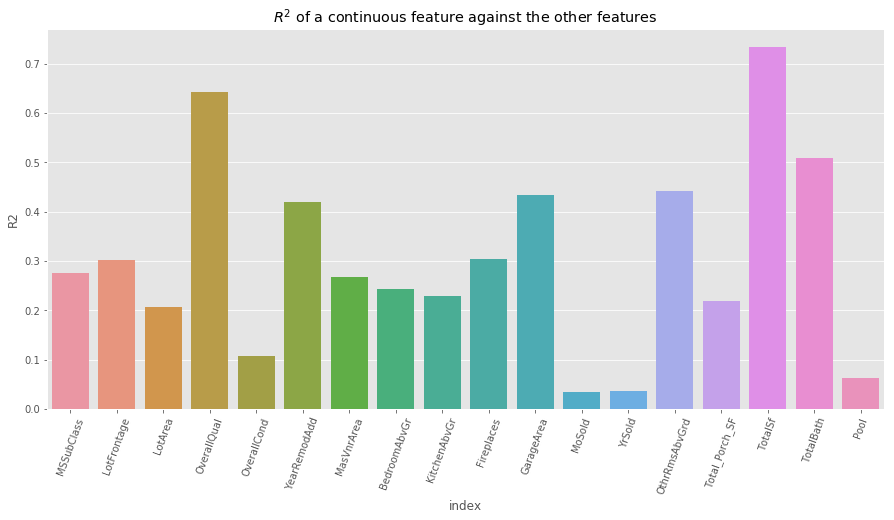

In [47]:
# Visualize multi-collinearity between non-dummified features
plt.figure(figsize=(15,7))
g = sns.barplot(x='index', y='R2', data=pd.DataFrame(scores, index=['R2']).T.reset_index())
plt.xticks(rotation=70)
plt.title('$R^2$ of a continuous feature against the other features')

In [48]:
# Use a simple multiple linear regression as a baseline, even though multi-collinearity 
# and curse of dimensionlity (many features) indicates this may be a bad choice
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score

linR = LinearRegression()
linR.fit(x_train, y_train)
linR_scores = cross_val_score(linR, x_train, y_train, cv=5)

print(np.mean(linR_scores))

0.8645418208715043


In [49]:
# Try a Lasso penalized regression - this has the advantage of helping with feature selection
# Find the optimum lambda
lr = Lasso(normalize=True)

params = {'alpha':10**np.linspace(-6,-3,100)}
grid = GridSearchCV(estimator=lr, param_grid=params, cv=5)

grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 8.697490026177834e-05}
0.8722458933722348


In [50]:
# Try a ridge regression
# Find the optimum lambda
rd = Ridge(normalize=True)

params = {'alpha':10**np.linspace(-2,2,100)}

grid = GridSearchCV(estimator=rd, param_grid=params, cv=5, n_jobs = -1)

grid.fit(x_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 0.21544346900318845}
0.8730706240054616


In [52]:
# Try an elasticnet regression
# Find the optimum lambda and rho
en = ElasticNet(max_iter=10000,normalize=True)

params = {'alpha':10**np.linspace(-4,0,20),'l1_ratio':np.linspace(0.1,1,20)}

grid = GridSearchCV(estimator=en, param_grid=params, cv=5, n_jobs = -1)

grid.fit(x_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 0.0001623776739188721, 'l1_ratio': 0.38421052631578945}
0.8755080150858497


In [ ]:
# Kaggle Submission #1
# Using the results of the above, get a baseline score from submitting the elasticnet 
# model, with no additional feature selection (other than that effected by the L1 penalty)
sub1 = pd.DataFrame(np.exp(grid.predict(test)),index=test.index+1,columns=['SalePrice'])
sub1.to_csv('sub1.csv',sep=',')

Text(0, 0.5, 'slope values')

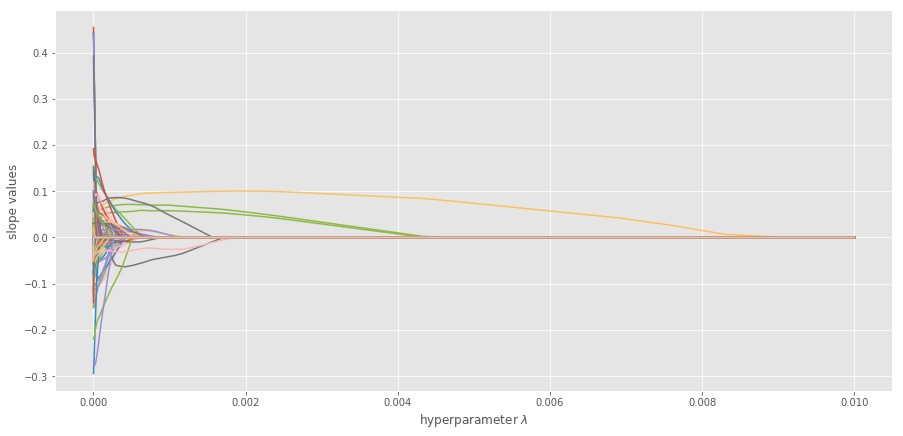

In [53]:
# Visualize the development of the model coefficients in Lasso regression
alphas = 10**np.linspace(-6,-2,100)
lr.set_params(normalize=True)
coefs  = []

for alpha in alphas:
        lr.set_params(alpha=alpha)
        lr.fit(x_train, y_train)  
        coefs.append(lr.coef_)
        
coefs = pd.DataFrame(coefs, index = alphas, columns = x_train.columns)

plt.figure(figsize=(15,7))
for name in coefs.columns:
    plt.plot(coefs.index, coefs[name], label=name)

plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')

In [54]:
# Find the ~10 coefficients that take the longest to go to zero
coefs[(coefs.index>0.001)][coefs[(coefs.index>0.001)]!=0].notnull().sum()

Unnamed: 0                0
MSSubClass                0
LotFrontage               0
LotArea                   0
OverallQual              23
OverallCond               0
YearRemodAdd              9
MasVnrArea                0
GrLivArea                 0
BedroomAbvGr              0
KitchenAbvGr              0
Fireplaces                2
GarageCars               16
GarageArea                0
MoSold                    0
YrSold                    0
OthrRmsAbvGrd             0
Total_Porch_SF            0
TotalSf                  21
TotalBath                16
Pool                      0
MSZoning_FV               0
MSZoning_RH               0
MSZoning_RL               1
MSZoning_RM               5
LotShape_IR2              0
LotShape_IR3              0
LotShape_Reg              0
LandContour_HLS           0
LandContour_Low           0
LandContour_Lvl           0
LotConfig_CulDSac         0
LotConfig_FR2             0
LotConfig_FR3             0
LotConfig_Inside          0
Neighborhood_Blueste

In [55]:
# Make a new feature space using only those features Lasso regression suggests have the
# most explanatory power
optimal_features = x_train.loc[:,['OverallQual','YearRemodAdd','GarageArea','Fireplaces','OthrRmsAbvGrd','TotalBath','MSZoning_RM','MSZoning_RL','MSZoning_RH','MSZoning_FV','CentralAir_Y','FireplaceQu_Gd','FireplaceQu_TA','TotalSf']]

In [56]:
# Run linear regression with the reduced feature set
linR = LinearRegression()
linR.fit(optimal_features,y_train)
linR_scores = cross_val_score(linR,optimal_features,y_train,cv=5)

print(np.mean(linR_scores))

0.8430624139646758


In [57]:
# # Run Lasso regression with the reduced feature set
lr = Lasso(normalize=True)

params = {'alpha':10**np.linspace(-6,-3,100)}
grid = GridSearchCV(estimator=lr,param_grid=params,cv=5,n_jobs = -1)


grid.fit(optimal_features,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 4.641588833612782e-06}
0.8431746905426631


In [58]:
# Run Ridge regression with the reduced feature set
rd = Ridge(normalize=True)

params = {'alpha':10**np.linspace(-4,2,100)}

grid = GridSearchCV(estimator=rd,param_grid=params,cv=5)

grid.fit(optimal_features,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 0.001873817422860383}
0.8431882739076854


In [ ]:
#Kaggle Submission #2
# Compare the previous submission to the result obtained from the Ridge regression with
# reduced feature set
sub2 = pd.DataFrame(np.exp(grid.predict(optimal_features_test)),index=optimal_features_test.index+1,columns=['SalePrice'])
sub2.to_csv('sub2.csv',sep=',')

In [59]:
# Run elasticnet regression with the reduced feature set
en = ElasticNet(max_iter=10000,normalize=True)

params = {'alpha':10**np.linspace(-7,-3,20),'l1_ratio':np.linspace(0.1,1,20)}

grid = GridSearchCV(estimator=en,param_grid=params,cv=5)

grid.fit(optimal_features,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 1.8329807108324375e-06, 'l1_ratio': 0.1}
0.8431879234870198


In [ ]:
# Investigate the value counts of all the categorical columns
all_categorical = all_data.select_dtypes(exclude=[np.number])
all_data.shape

In [ ]:
for col in all_categorical.columns:
    print(all_categorical[str(col)].value_counts())
    print('\n')

In [ ]:
all_data.GarageArea[all_data.GarageArea.isnull()]

In [ ]:
all_data.isnull().any()

In [ ]:
all_data.columns

In [ ]:
all_data.Condition2.value_counts()